Hello everyone! As usual, I was looking for some cool datasets that have been uploaded recently on Kaggle and I came across this dataset. I have been thinking to work on a similar kind of problem for long and I finally selected this one. Today we will be building an OCR using deep learning. Well, all the ideas presented here aren't new and much of inspiration for this comes from [this example](https://github.com/keras-team/keras/blob/master/examples/image_ocr.py) provided in the `Keras` repository.

### 1. Import the required libraries

In [1]:
# I don't like warning messages too much
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import gc
import cv2
import glob
import h5py
import shutil
import itertools
import random as rn

import imgaug as aug
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from pathlib import Path
from collections import Counter
import matplotlib.pyplot as plt
import imgaug.augmenters as iaa

from skimage.io import imread
from skimage.transform import resize
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.model_selection import train_test_split

from keras.models import Sequential, Model, load_model
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout
from keras.layers import Input, Flatten, BatchNormalization, Lambda
from keras.layers import CuDNNGRU, CuDNNLSTM, Bidirectional, LSTM, GRU
from keras.layers import Add, Concatenate, Reshape
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import to_categorical

from keras import backend as K
import tensorflow as tf


color = sns.color_palette()
%matplotlib inline
%config InlineBackend.figure_format="svg"

Using TensorFlow backend.


### 2. Reproducibility isn't a requirement, it's a necessity!

In [3]:
## I said it earlier as well, do everything you can to make your results reproducible. It matters!!

# Set the seed for hash based operations in python
os.environ['PYTHONHASHSEED'] = '0'

seed=1234

# set the seed for random number generator
rn.seed(seed)

# Set the numpy seed
np.random.seed(seed)

# Set the random seed in tensorflow at graph level
tf.set_random_seed(seed)

# We will be using CuDNN implementation of RNNs which already is non-reproducible
# So I am trying to get results as close as possible on different runs
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

# Make the augmentation sequence deterministic
aug.seed(seed)

### 3. Load the data 

In [4]:
# path to the data directory
data_dir = Path("../input/captcha/captcha/")

# getting list of all images
images = list(data_dir.glob("*.png"))
print("Number of images found: ", len(images))

Number of images found:  9955


Shape of image:  (24, 72, 3)
Shape of image:  (24, 72, 3)
Shape of image:  (24, 72, 3)
Shape of image:  (24, 72, 3)


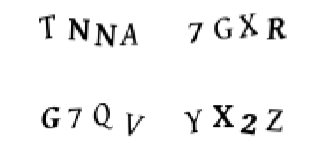

In [5]:
# Let's take a look at some samples first. 
# Always look at your data!
sample_images = images[:4]

f,ax = plt.subplots(2,2, figsize=(5,3))
for i in range(4):
    img = imread(sample_images[i])
    print("Shape of image: ", img.shape)
    ax[i//2, i%2].imshow(img)
    ax[i//2, i%2].axis('off')
plt.show()

So, we have around `10K` samples of data in total. The height, width and depth of images in the dataset are `24`, `72`, and `3` respectively. Becaue for a Captcha color isn't an important property, hence we will be using `grayscale` images for our use-case. Also, the images are already very small in size, so we won't be resizing them to some other size but if you want to experiemnt with that as well, feel free to do so. Everything is modular and requires only few changes.

Before that we need to know:
* What all `unique` alphanumeric characters are present in the images?
* What is the maximum length of any captcha? (This is needed to encode captcha to vectors)

Let's find out.

In [6]:
# make a set of all unique characters. Letter is a wrong
# word to use here but I am gonna use it for now.
letters = set()

# A list to store the max length for each catcha
lengths = []

# Iterate over each image. The name of the image is the 
# text ccontained in it. 
for image in images:
    image_name = str(image.name).split(".")[0]
    lengths.append(len(image_name))
    for ch in image_name:
        letters.add(ch)

# Sort the letters        
letters = sorted(letters)
print("Number of unqiue letters in the whole dataset: ", len(letters))
print("Maximum length of any captcha: ", max(Counter(lengths).keys()))
print("\nAll letters to be considered: ")
print(letters)

Number of unqiue letters in the whole dataset:  32
Maximum length of any captcha:  4

All letters to be considered: 
['2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


`pandas` dataframe is my favorite data structure to work with. We will make a dataframe that contains the path to the images and the corresponding labels/texts in the images.

In [7]:
dataset = []

for image in images:
    image_path = str(image)
    label = str(image.name).split(".")[0]
    dataset.append((image_path, label))

dataset = pd.DataFrame(dataset, columns=["img_path", "label"], index=None)
dataset = dataset.sample(frac=1.).reset_index(drop=True)
print("Total number of samples in the dataset: ", len(dataset))
dataset.head(10)

Total number of samples in the dataset:  9955


,img_path,label
0,../input/captcha/captcha/WU5H.png,WU5H
1,../input/captcha/captcha/W345.png,W345
2,../input/captcha/captcha/DY32.png,DY32
3,../input/captcha/captcha/JD9R.png,JD9R
4,../input/captcha/captcha/MGN2.png,MGN2
5,../input/captcha/captcha/8PMS.png,8PMS
6,../input/captcha/captcha/3H3F.png,3H3F
7,../input/captcha/captcha/2M5Y.png,2M5Y
8,../input/captcha/captcha/NRE7.png,NRE7
9,../input/captcha/captcha/HVV8.png,HVV8


### 4. Separate out training and validation datasets. 

In [8]:
# split into train and validation sets
training_data, validation_data = train_test_split(dataset, test_size=0.1, random_state=seed)

training_data = training_data.reset_index(drop=True)
validation_data = validation_data.reset_index(drop=True)

print("Number of training samples: ", len(training_data))
print("Number of validation samples: ", len(validation_data))

Number of training samples:  8959
Number of validation samples:  996


### 5. Some helper functions for pre-processing and post-processing

In [9]:
# function to create labels from text
def text_to_labels(text):
    return list(map(lambda x: letters.index(x), text))

# function to convert labels back to texts
def labels_to_text(label):
    return ''.join(list(map(lambda x: letters[int(x)], label)))

# sanity-check for letters
def is_valid_str(s):
    for ch in s:
        if not ch in letters:
            return False
    return True

### 6. Store the data in memory(if you can!)

In [10]:
def build_data(df, resize=True, img_height=24, img_width=72):
    """This function reads samples from a dataframe and store
    the image values and labels in two separate arrays.
    
    Args:
        df        : dataframe from which we want to read the data
        resize    : whether to resize images or not
        img_weidth: width of images to be considered
        img_height: height of images to be considered
        
    Returns:
        images    : numpy array of images
        labels    : numpy array of encoded labels
    """
    n = len(df)
    images = np.zeros((n, img_height, img_width), dtype=np.float32)
    labels = [0]*n
    for i in range(n):
        img = cv2.imread(df["img_path"][i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        if resize:
            img = cv2.resize(img, (img_width, img_height))
        
        img = (img/255.).astype(np.float32)
        label = df["label"][i]
        
        # only add to if all the charaters are valid
        if is_valid_str(label):
            images[i, :, :] = img
            labels[i] = label
    
    return images, np.array(labels)

In [11]:
# Building training data
training_images, training_labels = build_data(training_data)
print("Number of training images: ", training_images.shape)
print("Number of training labels: ", training_labels.shape)

Number of training images:  (8959, 24, 72)
Number of training labels:  (8959,)


In [12]:
# Building validation data
validation_images, validation_labels = build_data(validation_data)
print("Number of validation images: ", validation_images.shape)
print("Number of validation labels: ", validation_labels.shape)

Number of validation images:  (996, 24, 72)
Number of validation labels:  (996,)


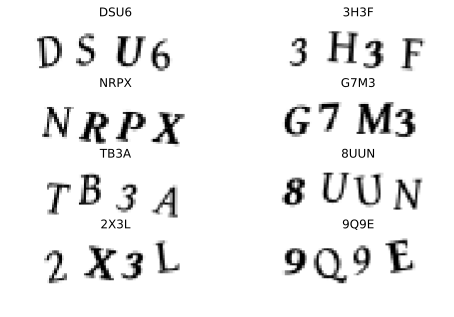

In [13]:
# Check some samples again
f,ax = plt.subplots(4,2, figsize=(8,5))
for i in range(4):
    ax[i//2, i%2].imshow(training_images[i], cmap='gray')
    ax[i//2, i%2].set_title(training_labels[i])
    ax[i//2, i%2].axis('off')

for i in range(4, 8):
    ax[i//2, i%2].imshow(validation_images[i], cmap='gray')
    ax[i//2, i%2].set_title(validation_labels[i])
    ax[i//2, i%2].axis('off')
    
plt.show()

Now that we have everything in place. It's time to start work towards a model building process but before that, we need to define a data generator. Pay attention to the details of the generator here. It is not a trivial generator. Don't worry about all the things that are defined inside the generator for now, you will get them fully once we have built our final model.

### 7. Data generator 

In [14]:
def data_generator(df, 
                   batch_size, 
                   img_width, 
                   img_height, 
                   downsample_factor, 
                   max_text_len, 
                   is_validation_data=False):
    """This is a data generator which yields batches 
    of (image, label) pairs.
    
    Args:
        df                : training or validation dataframe
        batch_size        : batch size ti be used during training
        img_width         : width of images to be considered  
        img_height        : height of images to be considered
        downsample_factor : by what factor the CNN has downsampled the images
        max_text_len      : maximum length of the text in your data
        is_validation_data: is the data being considered a validation data?
        
    Returns:
        inputs: numpy array containg inputs that are required for the final model
        outputs: a dummy array of zeros 
    """
    n = len(df)
    indices = np.arange(n)
    np.random.shuffle(indices)
    nb_batches = int(np.ceil(n/batch_size))
    
    if not is_validation_data:
        images, texts = training_images, training_labels
    else:
        images, texts = validation_images, validation_labels
    
    batch_images = np.ones((batch_size, img_width, img_height, 1), dtype=np.float32)
    batch_labels = np.ones((batch_size, max_text_len), dtype=np.float32)
    input_length = np.ones((batch_size, 1), dtype=np.int64) * \
                                            (img_width // downsample_factor - 2)
    label_length = np.zeros((batch_size, 1), dtype=np.int64)
    
    while True:
        for i in range(nb_batches):
            idx_to_consider = indices[i*batch_size:(i+1)*batch_size]
            
            for j, idx in enumerate(idx_to_consider):
                img = images[idx].T
                img = np.expand_dims(img, axis=-1)
                text = texts[idx]
                
                if is_valid_str(text):
                    label = text_to_labels(texts[idx])
                    batch_images[j] = img
                    batch_labels[j] = label
                    label_length[j] = len(text)

            inputs = {
            'input_data': batch_images,
            'input_label': batch_labels,
            'input_length': input_length,
            'label_length': label_length,
            }
            
            outputs = {'ctc_loss': np.zeros([batch_size], dtype=np.float32)}
            yield inputs, outputs

In [15]:
# batch size to be used for training
batch_size = 32

# image dimensions
img_width=72
img_height=24 

# by what factor the image has been downsampled by the CNN part?
downsample_factor=4

# maximum length of any text in the data
max_text_len=4

In [16]:
# Get a generator object for the training data
train_data_generator = data_generator(training_data, 
                                      batch_size=batch_size, 
                                      img_width=img_width, 
                                      img_height=img_height, 
                                      downsample_factor=downsample_factor, 
                                      max_text_len=max_text_len, 
                                      is_validation_data=False)

# Get a generator object for the validation data 
valid_data_generator = data_generator(validation_data, 
                                      batch_size=batch_size, 
                                      img_width=img_width, 
                                      img_height=img_height, 
                                      downsample_factor=downsample_factor, 
                                      max_text_len=max_text_len, 
                                      is_validation_data=True)

In [17]:
# A handy-dandy function for checking the generator output
# always sanity-check your data before passing it to the model
def visualize_data_gen_output(data_gen, samples_to_visualize=2):
    for i, (inp, out) in enumerate(data_gen):
        print('Text generator output (data which will be fed into the neutral network):')
        print('1)the_input (image)')
        img = (inp['input_data'][i, :, :, 0]*255).astype(np.uint8)
        plt.imshow(img.T, cmap='gray')
        plt.show()
        print(f"2) the_labels(captcha) {labels_to_text(inp['input_label'][i])} is encoded as {list(map(int, inp['input_label'][i]))}") 
        print(f"3) input_length (width of image that is fed to the network after CNN): {inp['input_length'][i][0]} == (72/4 - 2)")
        print(f"4) label_length (length of captcha): {inp['label_length'][i][0]}")
        print(" ")
        if i==samples_to_visualize:
            break

Text generator output (data which will be fed into the neutral network):
1)the_input (image)


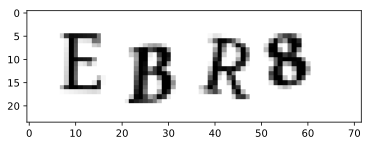

2) the_labels(captcha) EBR8 is encoded as [12, 9, 23, 6]
3) input_length (width of image that is fed to the network after CNN): 16 == (72/4 - 2)
4) label_length (length of captcha): 4
 
Text generator output (data which will be fed into the neutral network):
1)the_input (image)


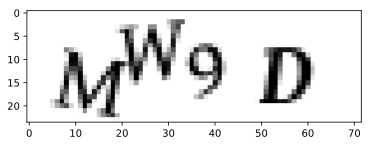

2) the_labels(captcha) MW9D is encoded as [19, 28, 7, 11]
3) input_length (width of image that is fed to the network after CNN): 16 == (72/4 - 2)
4) label_length (length of captcha): 4
 
Text generator output (data which will be fed into the neutral network):
1)the_input (image)


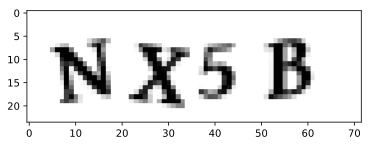

2) the_labels(captcha) NX5B is encoded as [20, 29, 3, 9]
3) input_length (width of image that is fed to the network after CNN): 16 == (72/4 - 2)
4) label_length (length of captcha): 4
 


In [18]:
visualize_data_gen_output(train_data_generator)

Text generator output (data which will be fed into the neutral network):
1)the_input (image)


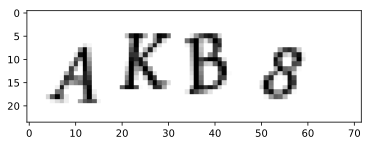

2) the_labels(captcha) AKB8 is encoded as [8, 17, 9, 6]
3) input_length (width of image that is fed to the network after CNN): 16 == (72/4 - 2)
4) label_length (length of captcha): 4
 
Text generator output (data which will be fed into the neutral network):
1)the_input (image)


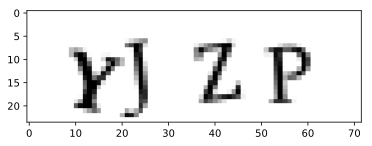

2) the_labels(captcha) YJZP is encoded as [30, 16, 31, 21]
3) input_length (width of image that is fed to the network after CNN): 16 == (72/4 - 2)
4) label_length (length of captcha): 4
 
Text generator output (data which will be fed into the neutral network):
1)the_input (image)


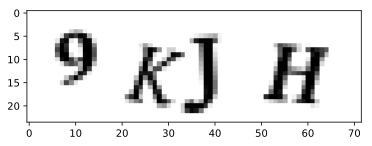

2) the_labels(captcha) 9KJH is encoded as [7, 17, 16, 15]
3) input_length (width of image that is fed to the network after CNN): 16 == (72/4 - 2)
4) label_length (length of captcha): 4
 


In [19]:
visualize_data_gen_output(valid_data_generator)

### 8. CTC loss function

In [20]:
# We will be using this loss function as the output
# The loss function in model.compile(..) will be a dummy one
# This is different from a normal scenario where you pass an actual 
# loss function when you compile the model
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage:
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

### 9. Model 

In [21]:
def build_model():
    # Inputs to the model
    input_img = Input(shape=(img_width, img_height, 1), name='input_data', dtype='float32')
    labels = Input(name='input_label', shape=[max_text_len], dtype='float32')
    input_length = Input(name='input_length', shape=[1], dtype='int64')
    label_length = Input(name='label_length', shape=[1], dtype='int64')
    
    # Convolution part for feaure extraction
    x = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same', name='Conv1')(input_img)
    x = MaxPooling2D((2,2), name='pool1')(x)
    x = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same', name='Conv2')(x)
    x = MaxPooling2D((2,2), name='pool2')(x)
    
    # Reshape the features for passing to RNN
    # We have used two max pool with pool size and strides of 2. Hence, downsampled is 4x smaller
    # Also, the number of filters in the last layer is 64.
    new_shape = ((img_width // 4), (img_height // 4)*64)
    x = Reshape(target_shape=new_shape, name='reshape')(x)
    x = Dense(64, activation='relu', name='dense1')(x)
    
    # RNNs
    x = Bidirectional(CuDNNLSTM(128, return_sequences=True,  name='lstm_1'), name='bi_1')(x)
    x = Bidirectional(CuDNNLSTM(128, return_sequences=True,  name='lstm_2'), name='bi_2')(x)
    
    # final part
    x = Dense(len(letters)+1, activation='softmax', name='dense2', kernel_initializer='he_normal')(x)
    
    # Get the CTC loss and represent it in a layer
    output = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc_loss')([x, labels, input_length, label_length])
    
    # define the final model
    model = Model([input_img, labels, input_length, label_length], output, name='ocr_model_v1')
    
    # optimizer
    sgd = SGD(lr=0.002, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)
    
    # the loss calc occurs elsewhere, so use a dummy lambda func for the loss
    # this is the reason we have this ctc_loss array of zeros in our generator
    model.compile(loss={'ctc_loss': lambda y_true, y_pred: y_pred}, optimizer=sgd)
    return model

In [22]:
model = build_model()
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_data (InputLayer)         (None, 72, 24, 1)    0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 72, 24, 32)   320         input_data[0][0]                 
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 36, 12, 32)   0           Conv1[0][0]                      
__________________________________________________________________________________________________
Conv2 (Conv2D)                  (None, 3

In [23]:
# things required for starting the training 
nb_epochs = 50
nb_train_steps = training_data.shape[0] // batch_size
nb_validation_steps = validation_data.shape[0] // batch_size
es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
ckpt = ModelCheckpoint(filepath='ocr_v2.h5', save_best_only=True, monitor='val_loss')

In [24]:
# Train the model
history = model.fit_generator(train_data_generator, 
                    epochs=nb_epochs, 
                    steps_per_epoch=nb_train_steps, 
                    validation_data=valid_data_generator, 
                    validation_steps=nb_validation_steps,
                    callbacks=[es, ckpt])

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/50
279/279 [==============================] - 11s 38ms/step - loss: 15.7600 - val_loss: 14.8219
Epoch 2/50
279/279 [==============================] - 6s 23ms/step - loss: 14.7358 - val_loss: 14.7297
Epoch 3/50
279/279 [==============================] - 6s 23ms/step - loss: 14.6739 - val_loss: 14.7580
Epoch 4/50
279/279 [==============================] - 7s 24ms/step - loss: 14.6533 - val_loss: 14.6936
Epoch 5/50
279/279 [==============================] - 7s 23ms/step - loss: 14.4946 - val_loss: 14.3377
Epoch 6/50
279/279 [==============================] - 6s 23ms/step - loss: 14.2279 - val_loss: 14.3092
Epoch 7/50
279/279 [==============================] - 6s 23ms/step - loss: 14.0977 - val_loss: 14.0813
Epoch 8/50
279/279 [==============================] - 6s 23ms/step - loss: 13.9252 - val_loss: 13.8487
Epoch 9/50
279/279 [==============================] - 6s 23ms/step - loss: 13.6780 - val_loss: 13

### 10. Testing the model

In [25]:
# A utility to decode the output of the network
def decode_batch_predictions(pred):
    pred = pred[:, 2:]
    input_len = np.ones(pred.shape[0])*pred.shape[1]
    
    # Use greedy search. For complex tasks, you can use beam search
    results = K.get_value(K.ctc_decode(pred, 
                                   input_length=input_len,
                                   greedy=True)[0][0])
    
    # Iterate over the results and get back the text
    texts = []
    for res in results:
        outstr = ''
        for c in res:
            if c < len(letters):
                outstr += letters[c]
        texts.append(outstr)
    
    # return final text results
    return texts

In [26]:
# Get the input output layer and define a Keras function
# It is similar to getting layers in tensorflow and 
# passing the information to the session.
output_func = K.function([model.get_layer(name='input_data').input],
                        [model.get_layer(name='dense2').output])


#  Let's check results on some validation samples
for p, (inp_value, _) in enumerate(valid_data_generator):
    bs = inp_value['input_data'].shape[0]
    X_data = inp_value['input_data']
    labels = inp_value['input_label']
    
    preds = output_func([X_data])[0]
    pred_texts = decode_batch_predictions(preds)
    
    
    orig_texts = []
    for label in labels:
        text = ''.join(list(map(lambda x: letters[int(x)], label)))
        orig_texts.append(text)
        
    for i in range(bs):
        print(f'GT: {orig_texts[i]} \t Predicted: {pred_texts[i]}')
    break

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
GT: EG3L 	 Predicted: EG3L
GT: 6SLM 	 Predicted: 6SLM
GT: XDVK 	 Predicted: XDVK
GT: SMNK 	 Predicted: SMNK
GT: Y44W 	 Predicted: Y44W
GT: 8MRD 	 Predicted: 8MRD
GT: 6CNE 	 Predicted: 6CNE
GT: Y8BX 	 Predicted: Y8BX
GT: NUQG 	 Predicted: NUQG
GT: DVYY 	 Predicted: DVYY
GT: B9BA 	 Predicted: B9BA
GT: PPUQ 	 Predicted: PPUQ
GT: EMDF 	 Predicted: EMDF
GT: RLGM 	 Predicted: RLGM
GT: N6FC 	 Predicted: N6FC
GT: ZPFE 	 Predicted: ZPFE
GT: QYJE 	 Predicted: QYJE
GT: 9Q9E 	 Predicted: 9Q9E
GT: KAQT 	 Predicted: KAQT
GT: FHDJ 	 Predicted: FHDJ
GT: 6JJ4 	 Predicted: 6JJ4
GT: 7GB8 	 Predicted: 7GB8
GT: 8SZL 	 Predicted: 8SZL
GT: RKSC 	 Predicted: RKSC
GT: WPHX 	 Predicted: WPHX
GT: 765A 	 Predicted: 765A
GT: DBWZ 	 Predicted: DBWZ
GT: WZZD 	 Predicted: WZZD
GT: 4WWU 	 Predicted: 4WWU
GT: W3UX 	 Predicted: W3UX
GT: XE8S 	 Predicted: XE8S
GT: AX2M 	 Predicted: AX2M


**Hooray!!** We have successfully build a captcha cracker with minimal efforts. That's it folks! I hope you have enjoyed this. If yes, please don't forget to **upvote** to show your appreciation.